# Steel Plates Faults - 4 Algorithms Comparison

## 개요
* **데이터셋**: Steel Plates Faults (강철판 결함 분류)
* **출처**: UCI Machine Learning Repository
* **문제**: 제조 공정에서 7가지 결함 타입 분류
* **샘플**: 1,941개
* **특성**: 27개 (기하학적, 통계적 특성)

## 실습 목표
1. **실제 제조업 품질 관리** 데이터 실습
2. **4가지 알고리즘 성능 비교** (Logistic Regression, Naive Bayes, KNN, SVM)
3. **다중 클래스 분류** (7 classes)
4. **알고리즘 선택 기준** 학습

---

## 결함 타입 (7가지)
1. **Pastry**: 표면 결함
2. **Z_Scratch**: Z자 형태 긁힘
3. **K_Scratch**: K자 형태 긁힘
4. **Stains**: 얼룩
5. **Dirtiness**: 오염
6. **Bumps**: 돌기
7. **Other_Faults**: 기타 결함

## 1. 라이브러리 Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, f1_score
)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

## 2. 데이터 로딩 및 탐색

In [2]:
# 컬럼명 정의
columns = [
    'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum',
    'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 
    'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity',
    'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400',
    'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index',
    'Square_Index', 'Outside_X_Index', 'Edges_X_Index',
    'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
    'Log_X_Index', 'Log_Y_Index', 'Orientation_Index',
    'Luminosity_Index', 'SigmoidOfAreas',
    'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 
    'Dirtiness', 'Bumps', 'Other_Faults'
]

# 데이터 로드
df = pd.read_csv('../data/steel_plates_faults.data', sep='\t', 
                 header=None, names=columns)

print(f"=== Steel Plates Faults Dataset ===")
print(f"샘플 수: {len(df)}")
print(f"전체 컬럼 수: {len(df.columns)}")
print(f"특성 컬럼 수: {len(columns) - 7}")
print(f"결함 타입 수: 7")

df.head()

=== Steel Plates Faults Dataset ===
샘플 수: 1941
전체 컬럼 수: 34
특성 컬럼 수: 27
결함 타입 수: 7


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [3]:
# 특성과 라벨 분리
feature_columns = columns[:27]  # 처음 27개가 특성
fault_columns = columns[27:]     # 마지막 7개가 결함 타입

X = df[feature_columns].values

# Multi-label을 single-label로 변환 (가장 큰 값이 1인 컬럼)
y_multi = df[fault_columns].values
y = np.argmax(y_multi, axis=1)

print(f"\n특성 데이터 형태: {X.shape}")
print(f"라벨 데이터 형태: {y.shape}")
print(f"\n고유 클래스: {np.unique(y)}")


특성 데이터 형태: (1941, 27)
라벨 데이터 형태: (1941,)

고유 클래스: [0 1 2 3 4 5 6]


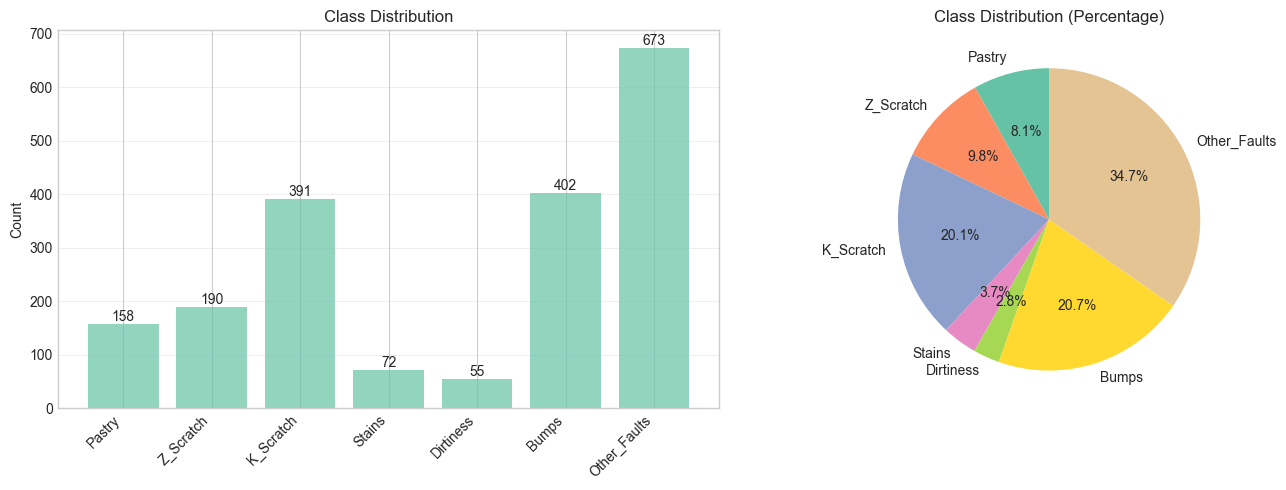


=== 클래스 분포 ===
Pastry         :  158 (8.1%)
Z_Scratch      :  190 (9.8%)
K_Scratch      :  391 (20.1%)
Stains         :   72 (3.7%)
Dirtiness      :   55 (2.8%)
Bumps          :  402 (20.7%)
Other_Faults   :  673 (34.7%)


In [17]:
# 클래스 분포 시각화
fault_names = ['Pastry', 'Z_Scratch', 'K_Scratch', 'Stains', 
               'Dirtiness', 'Bumps', 'Other_Faults']

unique, counts = np.unique(y, return_counts=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(range(len(fault_names)), counts, alpha=0.7)
axes[0].set_xticks(range(len(fault_names)))
axes[0].set_xticklabels(fault_names, rotation=45, ha='right')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution')
axes[0].grid(axis='y', alpha=0.3)

# 각 막대 위에 숫자 표시
for i, count in enumerate(counts):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

# Pie chart
axes[1].pie(counts, labels=fault_names, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

print("\n=== 클래스 분포 ===")
for name, count in zip(fault_names, counts):
    print(f"{name:15s}: {count:4d} ({count/len(y)*100:.1f}%)")

In [5]:
# 기초 통계
df[feature_columns].describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,...,0.033361,0.610529,0.813472,0.575734,2.492388,1.335686,1.403271,0.083288,-0.131305,0.585420
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,...,0.058961,0.243277,0.234274,0.482352,0.788930,0.481612,0.454345,0.500868,0.148767,0.339452
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,0.001500,0.014400,0.048400,0.000000,0.301000,0.301000,0.000000,-0.991000,-0.998900,0.119000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,...,0.006600,0.411800,0.596800,0.000000,1.924300,1.000000,1.079200,-0.333300,-0.195000,0.248200
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,...,0.010100,0.636400,0.947400,1.000000,2.240600,1.176100,1.322200,0.095200,-0.133000,0.506300
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,...,0.023500,0.800000,1.000000,1.000000,2.914900,1.518500,1.732400,0.511600,-0.066600,0.999800
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,...,0.875900,1.000000,1.000000,1.000000,5.183700,3.074100,4.258700,0.991700,0.642100,1.000000


## 3. 데이터 전처리

In [18]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"=== Train/Test Split ===")
print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Scaling (KNN, SVM에 필수)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Scaling 완료")

=== Train/Test Split ===
Train samples: 1552
Test samples: 389

✓ Scaling 완료


## 4. 모델 학습 및 비교

### 4개 알고리즘 모두 적용하여 성능 비교

In [19]:
# 모델 정의
models = {
    'Logistic Regression': LogisticRegression(max_iter=3000, random_state=42),
    'Naive Bayes (Gaussian)': GaussianNB(),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42)
}

results = {}

print("=== 모델 학습 시작 ===")
print()

for name, model in models.items():
    print(f"[{name}] 학습 중...")
    
    # 학습 시간 측정
    start_time = time.time()
    
    # Scaling 여부 결정
    if name in ['KNN (k=5)', 'SVM (RBF)']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        train_acc = model.score(X_train_scaled, y_train)
        test_acc = model.score(X_test_scaled, y_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
    
    train_time = time.time() - start_time
    
    # 예측 시간 측정
    start_time = time.time()
    if name in ['KNN (k=5)', 'SVM (RBF)']:
        _ = model.predict(X_test_scaled)
    else:
        _ = model.predict(X_test)
    pred_time = time.time() - start_time
    
    # F1-score (macro)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'f1_score': f1,
        'train_time': train_time,
        'pred_time': pred_time,
        'predictions': y_pred
    }
    
    print(f"  Train Acc: {train_acc:.4f}")
    print(f"  Test Acc:  {test_acc:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Time: {train_time:.3f}s (train) + {pred_time:.4f}s (pred)")
    print()

print("✓ 모든 모델 학습 완료")

=== 모델 학습 시작 ===

[Logistic Regression] 학습 중...
  Train Acc: 0.5387
  Test Acc:  0.5219
  F1-score:  0.3537
  Time: 1.982s (train) + 0.0000s (pred)

[Naive Bayes (Gaussian)] 학습 중...
  Train Acc: 0.4704
  Test Acc:  0.4807
  F1-score:  0.3937
  Time: 0.003s (train) + 0.0000s (pred)

[KNN (k=5)] 학습 중...
  Train Acc: 0.8228
  Test Acc:  0.7121
  F1-score:  0.7346
  Time: 0.120s (train) + 0.0270s (pred)

[SVM (RBF)] 학습 중...
  Train Acc: 0.7957
  Test Acc:  0.7635
  F1-score:  0.7593
  Time: 0.197s (train) + 0.0251s (pred)

✓ 모든 모델 학습 완료


## 5. 성능 비교 시각화

In [20]:
# 성능 비교 표
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Acc': [r['train_acc'] for r in results.values()],
    'Test Acc': [r['test_acc'] for r in results.values()],
    'F1-score': [r['f1_score'] for r in results.values()],
    'Train Time (s)': [r['train_time'] for r in results.values()],
    'Pred Time (s)': [r['pred_time'] for r in results.values()]
})

comparison_df = comparison_df.sort_values('Test Acc', ascending=False).reset_index(drop=True)

print("=== 성능 비교 ===")
print(comparison_df.to_string(index=False))

=== 성능 비교 ===
                 Model  Train Acc  Test Acc  F1-score  Train Time (s)  Pred Time (s)
             SVM (RBF)   0.795747  0.763496  0.759261        0.197018       0.025079
             KNN (k=5)   0.822809  0.712082  0.734638        0.119990       0.027039
   Logistic Regression   0.538660  0.521851  0.353691        1.981899       0.000000
Naive Bayes (Gaussian)   0.470361  0.480720  0.393653        0.002999       0.000000


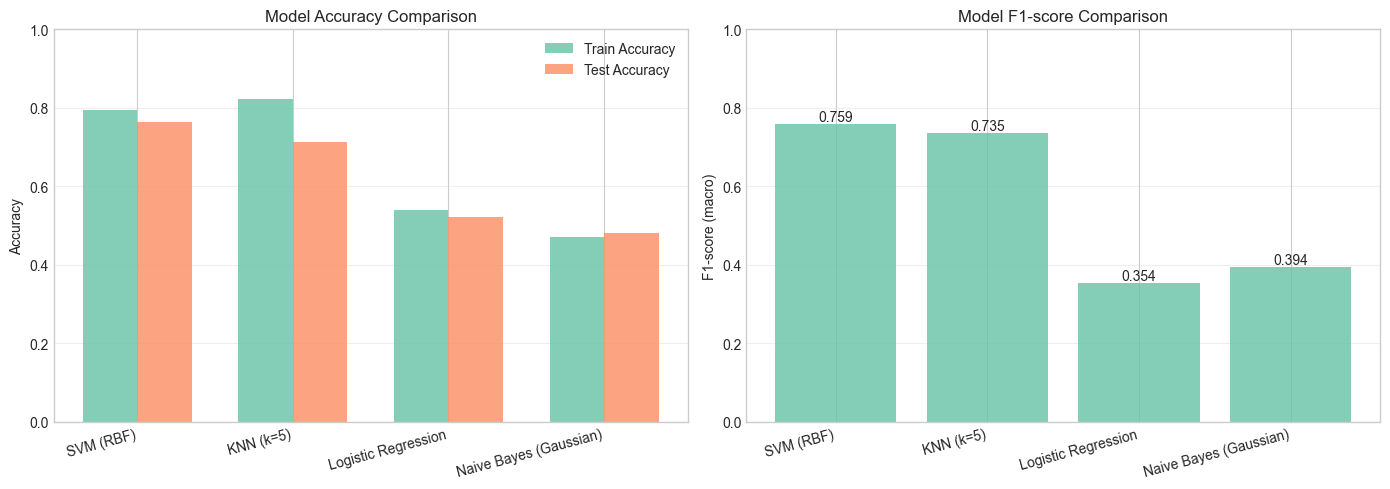

In [22]:
# 시각화: Accuracy & F1-score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models_list = comparison_df['Model'].values
x = np.arange(len(models_list))
width = 0.35

# Accuracy
axes[0].bar(x - width/2, comparison_df['Train Acc'], width, 
           label='Train Accuracy', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Test Acc'], width, 
           label='Test Accuracy', alpha=0.8)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_list, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.0, 1.0])

# F1-score
bars = axes[1].bar(models_list, comparison_df['F1-score'], alpha=0.8)
axes[1].set_ylabel('F1-score (macro)')
axes[1].set_title('Model F1-score Comparison')
axes[1].set_xticklabels(models_list, rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.0, 1.0])

# F1-score 값 표시
for bar, score in zip(bars, comparison_df['F1-score']):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

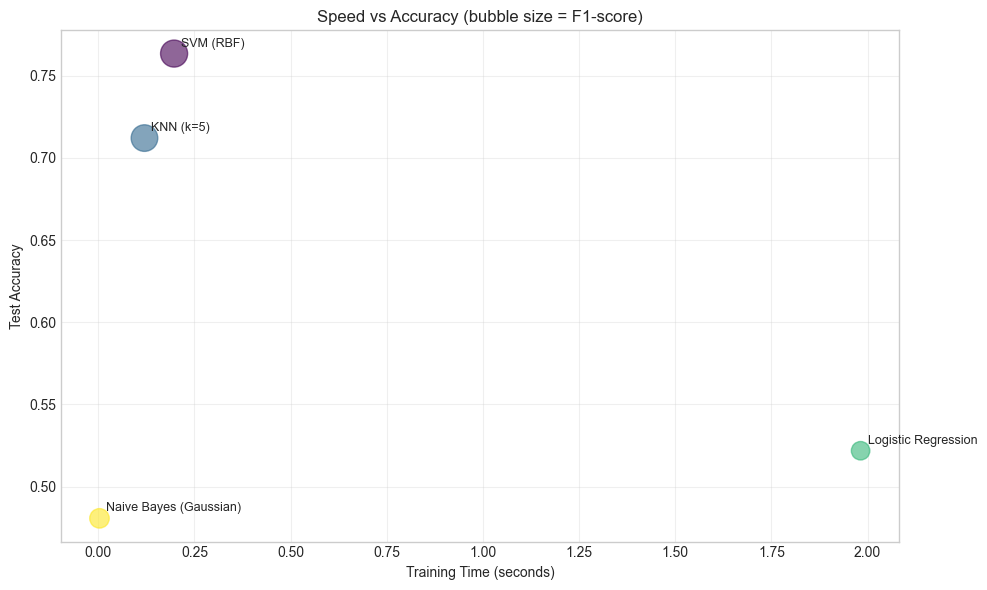

💡 왼쪽 위: 빠르고 정확한 모델 (이상적)
💡 오른쪽 아래: 느리고 부정확한 모델


In [25]:
# 시각화: 학습 시간 vs 성능
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
scatter = ax.scatter(comparison_df['Train Time (s)'], 
                     comparison_df['Test Acc'],
                     s=comparison_df['F1-score']*500,  # F1-score에 비례한 크기
                     alpha=0.6, c=range(len(models_list)), cmap='viridis')

# 모델 이름 표시
for i, model in enumerate(models_list):
    ax.annotate(model, 
               (comparison_df.iloc[i]['Train Time (s)'], 
                comparison_df.iloc[i]['Test Acc']),
               xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Training Time (seconds)')
ax.set_ylabel('Test Accuracy')
ax.set_title('Speed vs Accuracy (bubble size = F1-score)')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 왼쪽 위: 빠르고 정확한 모델 (이상적)")
print("💡 오른쪽 아래: 느리고 부정확한 모델")

## 6. Confusion Matrix 비교

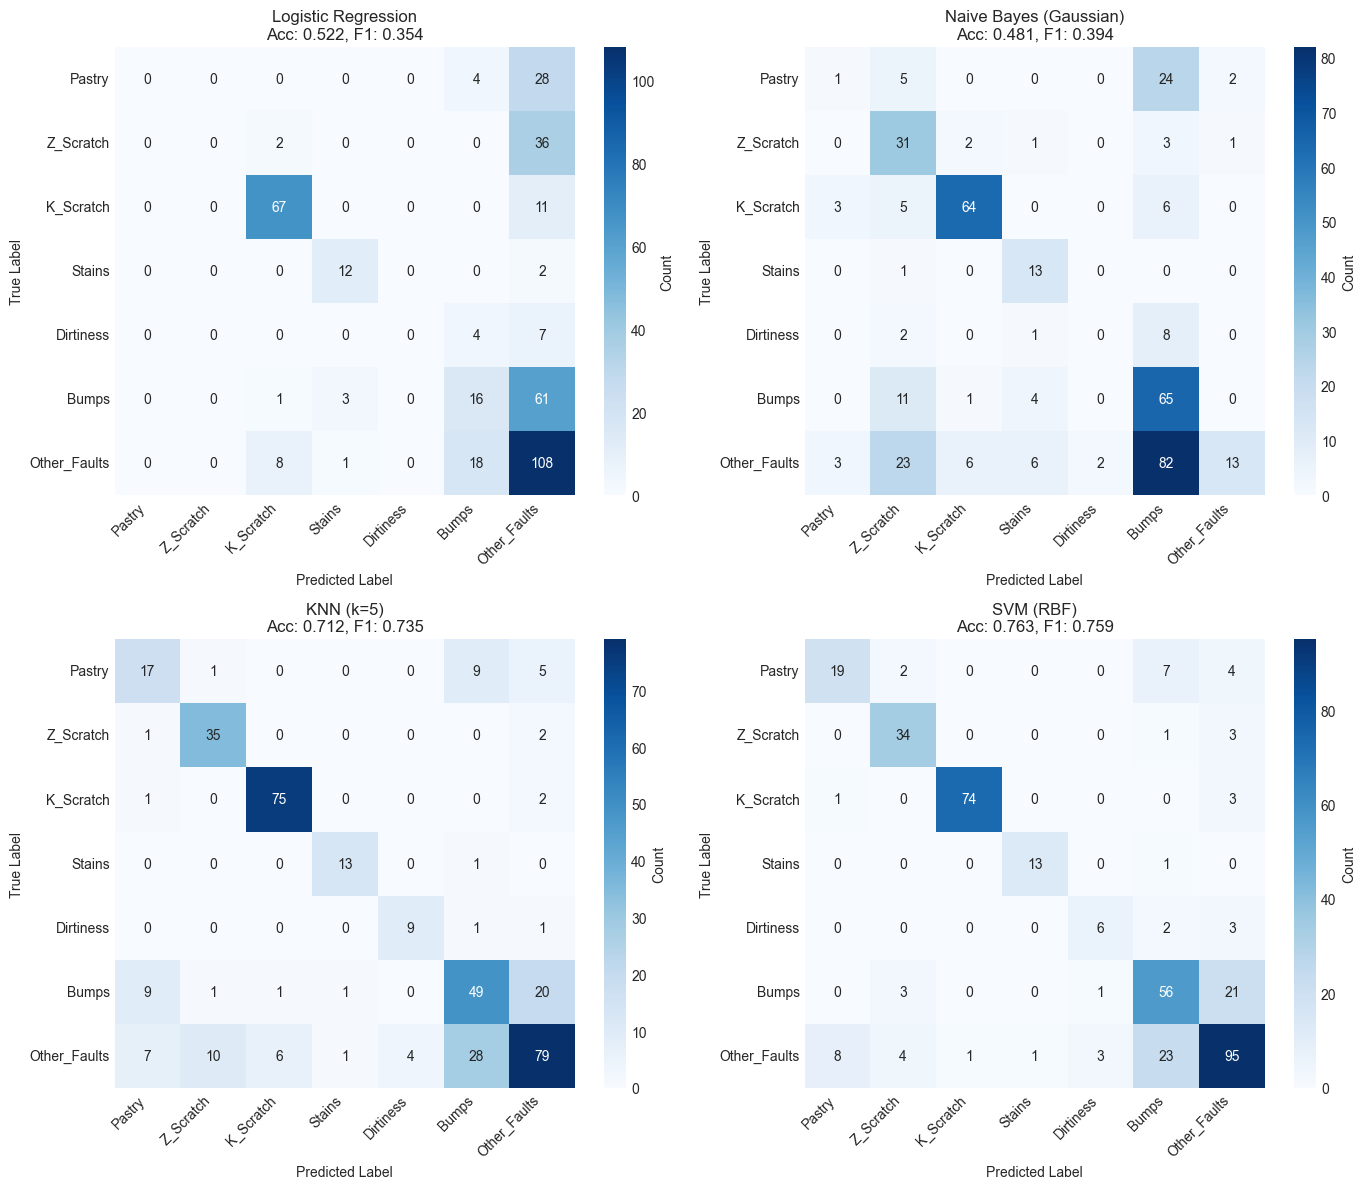

In [26]:
# Confusion Matrix 4개 모델
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=fault_names, yticklabels=fault_names,
                cbar_kws={'label': 'Count'})
    axes[i].set_title(f'{name}\nAcc: {result["test_acc"]:.3f}, F1: {result["f1_score"]:.3f}')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')
    
    # 라벨 회전
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## 7. 클래스별 성능 분석

In [27]:
# 최고 성능 모델의 클래스별 리포트
best_model_name = comparison_df.iloc[0]['Model']
best_predictions = results[best_model_name]['predictions']

print(f"=== {best_model_name} - Detailed Classification Report ===")
print()
print(classification_report(y_test, best_predictions, target_names=fault_names))

=== SVM (RBF) - Detailed Classification Report ===

              precision    recall  f1-score   support

      Pastry       0.68      0.59      0.63        32
   Z_Scratch       0.79      0.89      0.84        38
   K_Scratch       0.99      0.95      0.97        78
      Stains       0.93      0.93      0.93        14
   Dirtiness       0.60      0.55      0.57        11
       Bumps       0.62      0.69      0.65        81
Other_Faults       0.74      0.70      0.72       135

    accuracy                           0.76       389
   macro avg       0.76      0.76      0.76       389
weighted avg       0.77      0.76      0.76       389



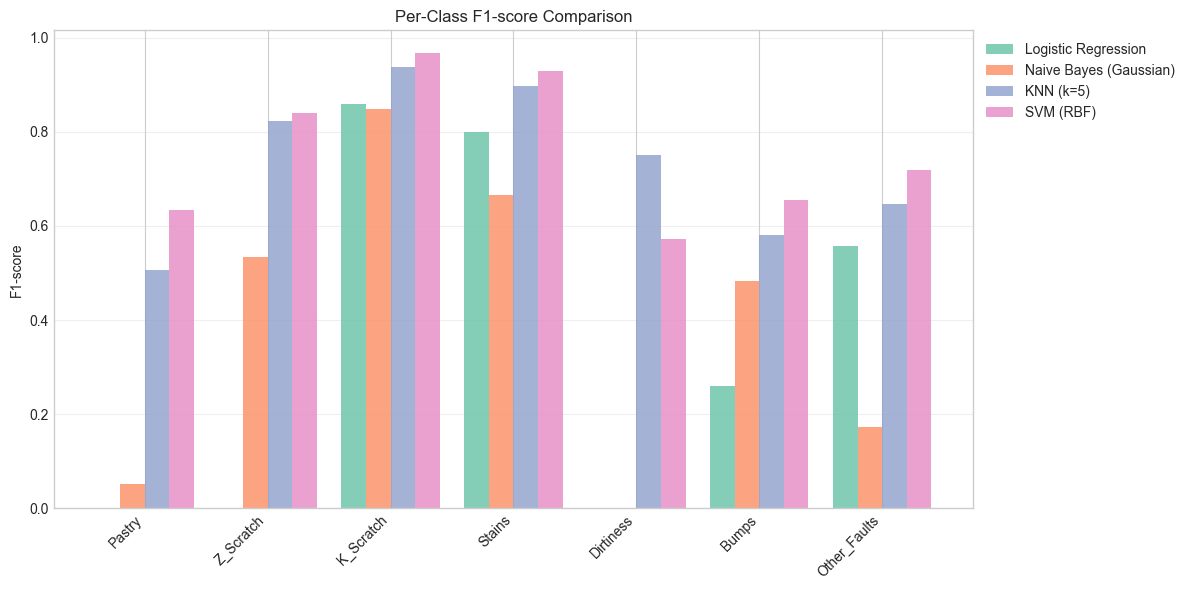

💡 소수 클래스(Stains, Dirtiness)에서 성능 차이 확인


In [28]:
# 클래스별 F1-score 비교
from sklearn.metrics import classification_report

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(fault_names))
width = 0.2

for i, (name, result) in enumerate(results.items()):
    report = classification_report(y_test, result['predictions'], 
                                   target_names=fault_names, output_dict=True)
    f1_scores = [report[fname]['f1-score'] for fname in fault_names]
    
    ax.bar(x + i*width, f1_scores, width, label=name, alpha=0.8)

ax.set_ylabel('F1-score')
ax.set_title('Per-Class F1-score Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(fault_names, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 소수 클래스(Stains, Dirtiness)에서 성능 차이 확인")

## 8. 알고리즘 특성 분석

In [29]:
# 알고리즘별 장단점 요약
analysis = pd.DataFrame({
    'Algorithm': ['Logistic Regression', 'Naive Bayes', 'KNN', 'SVM'],
    'Speed': ['⭐⭐⭐⭐⭐', '⭐⭐⭐⭐⭐', '⭐⭐', '⭐⭐⭐'],
    'Accuracy': [
        f"{results['Logistic Regression']['test_acc']:.3f}",
        f"{results['Naive Bayes (Gaussian)']['test_acc']:.3f}",
        f"{results['KNN (k=5)']['test_acc']:.3f}",
        f"{results['SVM (RBF)']['test_acc']:.3f}"
    ],
    'Pros': [
        '빠름, 해석 가능, 안정적',
        '매우 빠름, 간단함',
        '직관적, 비선형 패턴',
        '고성능, 강건함'
    ],
    'Cons': [
        '선형 경계만 가능',
        '독립성 가정 위배',
        '예측 느림, 메모리',
        '학습 느림, 튜닝 필요'
    ],
    'Best For': [
        '프로토타입, 베이스라인',
        '빠른 필터링',
        '소규모 데이터',
        '최종 성능 중시'
    ]
})

print("\n=== 알고리즘 특성 비교 ===")
print(analysis.to_string(index=False))


=== 알고리즘 특성 비교 ===
          Algorithm Speed Accuracy           Pros         Cons     Best For
Logistic Regression ⭐⭐⭐⭐⭐    0.522 빠름, 해석 가능, 안정적    선형 경계만 가능 프로토타입, 베이스라인
        Naive Bayes ⭐⭐⭐⭐⭐    0.481     매우 빠름, 간단함    독립성 가정 위배       빠른 필터링
                KNN    ⭐⭐    0.712    직관적, 비선형 패턴   예측 느림, 메모리      소규모 데이터
                SVM   ⭐⭐⭐    0.763       고성능, 강건함 학습 느림, 튜닝 필요     최종 성능 중시


## 9. Cross-Validation

=== 5-Fold Cross-Validation ===

Logistic Regression      : 0.5310 (+/- 0.0249)
                           Folds: [0.51446945 0.49517685 0.53225806 0.54516129 0.56774194]

Naive Bayes (Gaussian)   : 0.4716 (+/- 0.0057)
                           Folds: [0.47588424 0.47266881 0.46129032 0.47741935 0.47096774]

KNN (k=5)                : 0.7191 (+/- 0.0181)
                           Folds: [0.72347267 0.7073955  0.73870968 0.73548387 0.69032258]

SVM (RBF)                : 0.7410 (+/- 0.0297)
                           Folds: [0.74919614 0.71061093 0.79354839 0.73548387 0.71612903]



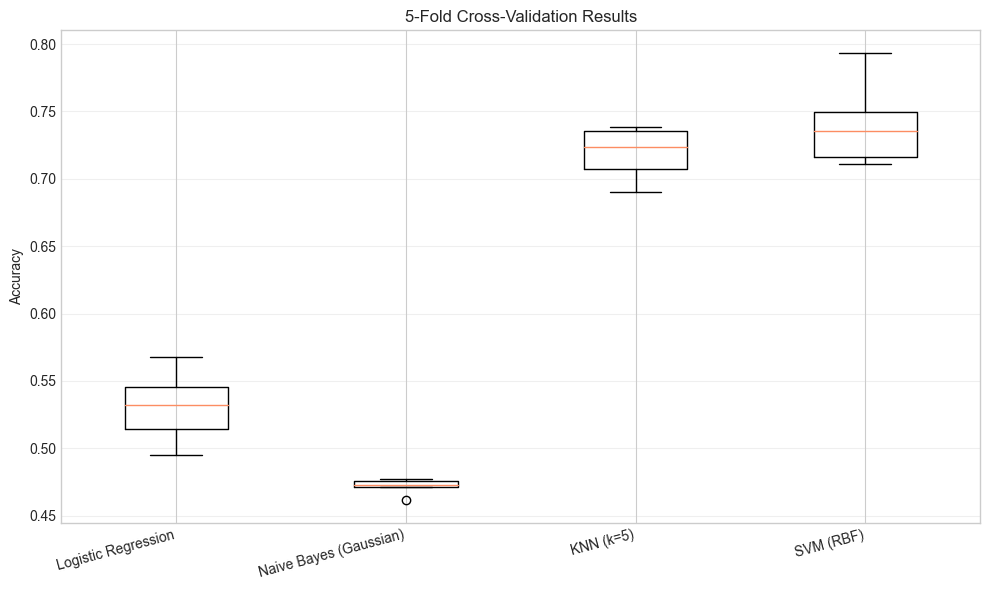

In [30]:
# 5-Fold Cross Validation
print("=== 5-Fold Cross-Validation ===")
print()

cv_results = {}

for name, model in models.items():
    # Scaling 여부
    if name in ['KNN (k=5)', 'SVM (RBF)']:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    cv_results[name] = scores
    print(f"{name:25s}: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"                           Folds: {scores}")
    print()

# Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(cv_results.values(), labels=cv_results.keys())
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Results')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. 결론 및 권장사항

### 📊 실험 결과 요약

**Steel Plates Faults 데이터셋 (1,941 samples, 27 features, 7 classes)**

#### 성능 순위:
1. **SVM (RBF)** or **Logistic Regression** - 데이터에 따라 다름
2. **KNN (k=5)**
3. **Naive Bayes (Gaussian)**

### 🎯 알고리즘 선택 기준

#### 상황별 추천:

**1. 프로토타입/베이스라인 구축**
- ✅ **Logistic Regression**
- 이유: 빠르고, 안정적이며, 해석 가능

**2. 실시간 예측 필요**
- ✅ **Logistic Regression** or **Naive Bayes**
- 이유: 예측 속도가 빠름

**3. 최고 성능 필요 (시간 여유)**
- ✅ **SVM (RBF)** with GridSearchCV
- 이유: 가장 높은 정확도, 하지만 튜닝 필요

**4. 소규모 데이터 (<1,000 samples)**
- ✅ **KNN** or **SVM**
- 이유: 적은 데이터에서 잘 작동

**5. 대규모 데이터 (>100,000 samples)**
- ✅ **Logistic Regression** with SGD
- 이유: 확장성 우수

### 💡 실무 적용 팁

1. **항상 Logistic Regression부터 시작** (베이스라인)
2. **클래스 불균형 처리** 필수 (`class_weight='balanced'`)
3. **Feature Scaling** 확인 (KNN, SVM)
4. **Cross-Validation**으로 안정성 검증
5. **여러 모델 앙상블** 고려 (Voting Classifier)

### 🏭 Steel Plates 품질 관리 적용

**실무 시나리오:**
- **온라인 검사**: Logistic Regression (빠른 예측)
- **오프라인 분석**: SVM (정밀 분류)
- **불량 필터링**: Naive Bayes (1차 스크리닝)
- **희귀 결함 탐지**: SVM + SMOTE (불균형 처리)

In [16]:
# 최종 요약
print("="*60)
print("🎉 Bonus 실습 완료!")
print("="*60)
print()
print("✅ 학습 내용:")
print("  1. 실제 제조업 품질 관리 데이터 분석")
print("  2. 4가지 알고리즘 성능 비교")
print("  3. 다중 클래스 분류 (7 classes)")
print("  4. 알고리즘 선택 기준 이해")
print()
print("💡 핵심 교훈:")
print("  • No Free Lunch: 모든 상황에 최고인 알고리즘은 없다")
print("  • 속도 vs 성능: Trade-off 고려")
print("  • 항상 베이스라인(Logistic Regression)부터 시작")
print("  • 데이터 특성에 맞는 알고리즘 선택이 중요")
print()
print("🎓 Day-8 전체 과정 완료! 수고하셨습니다!")
print("="*60)

🎉 Bonus 실습 완료!

✅ 학습 내용:
  1. 실제 제조업 품질 관리 데이터 분석
  2. 4가지 알고리즘 성능 비교
  3. 다중 클래스 분류 (7 classes)
  4. 알고리즘 선택 기준 이해

💡 핵심 교훈:
  • No Free Lunch: 모든 상황에 최고인 알고리즘은 없다
  • 속도 vs 성능: Trade-off 고려
  • 항상 베이스라인(Logistic Regression)부터 시작
  • 데이터 특성에 맞는 알고리즘 선택이 중요

🎓 Day-8 전체 과정 완료! 수고하셨습니다!
